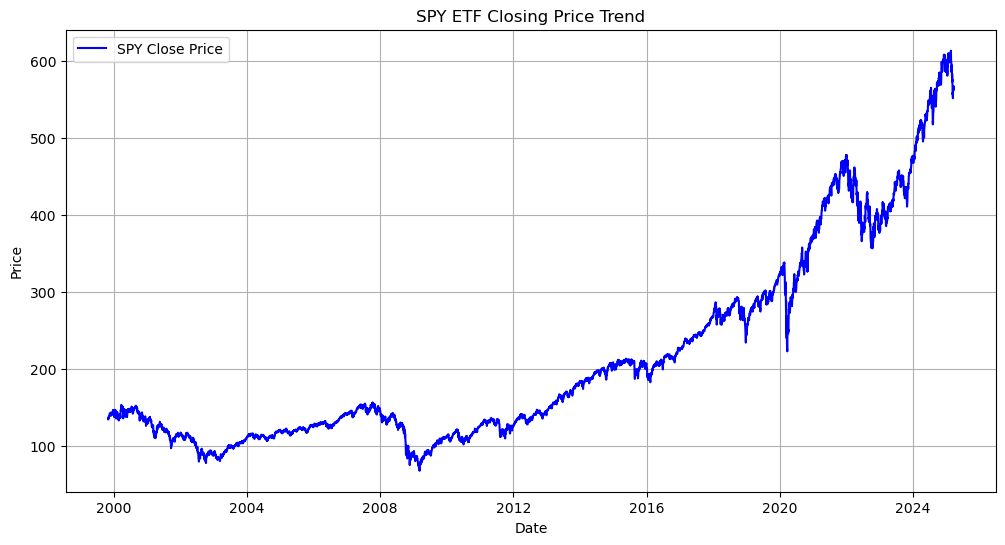

Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0051 - mae: 0.0417 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 4.1521e-04 - mae: 0.0142 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 3/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 3.7723e-04 - mae: 0.0134 - val_loss: 0.0031 - val_mae: 0.0486
Epoch 4/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 3.7494e-04 - mae: 0.0131 - val_loss: 8.8066e-04 - val_mae: 0.0224
Epoch 5/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 2.9864e-04 - mae: 0.0119 - val_loss: 0.0042 - val_mae: 0.0566
Epoch 6/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 2.5806e-04 - mae: 0.0110 - val_loss: 0.0022 - val_mae: 0.0403
Epoch 7/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 2.6762e-04 - mae: 0.0111 - val_loss: 0.0026 - val_mae: 0.0447
Epoch 8/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 2.1272e-04 - mae: 0.0099 - val_loss: 6.2162e-04 - val_mae: 0.0184
Epoch 9/25
159/159 ━━━━

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from alpha_vantage.timeseries import TimeSeries
import datetime

# Alpha Vantage API Setup
API_KEY = "8GSUEKGWPTI4YGE3"
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Fetching SPY ETF data using Alpha Vantage
data, meta_data = ts.get_daily(symbol='SPY', outputsize='full')

# Reverse data to have oldest to newest
spy_data = data.sort_index()
spy_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plotting trend
plt.figure(figsize=(12, 6))
plt.plot(spy_data['Close'], label='SPY Close Price', color='blue')
plt.title('SPY ETF Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Prepare Data for LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(spy_data['Close'].values.reshape(-1, 1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

# Save the model
model.save('advanced_spy_prediction_model.h5')



In [ ]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Kernel 1: Predict future stock price
model = load_model('advanced_spy_prediction_model.h5')
real_data = [scaled_data[-prediction_days:]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

predicted_price = model.predict(real_data)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted SPY price for the next day: ${predicted_price[0][0]:.2f}")

In [ ]:
# Kernel 2: Calculate investment returns
initial_year = int(input("Enter the initial year of investment (e.g., 2010): "))
initial_price = spy_data.loc[f'{initial_year}-01-01':f'{initial_year}-12-31']['Close'].mean()
current_price = spy_data['Close'][-1]

investment_amount = float(input("Enter investment amount (USD): "))
initial_shares = investment_amount / initial_price
current_value = initial_shares * current_price
return_percent = ((current_value - investment_amount) / investment_amount) * 100

print(f"If you invested ${investment_amount:.2f} in {initial_year}, your investment would now be worth ${current_value:.2f}, a return of {return_percent:.2f}%.")
